In [1]:
#importing libraries
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model, save_model

import matplotlib.pyplot as plt
import seaborn as sb

from warnings import filterwarnings
filterwarnings('ignore')

## Reading and Processing Data

In [5]:
#path of data set
directory = r"D:\research_project\Segmented Medicinal Leaf Images"

In [6]:
batch_size = 64
IMG_SIZE = (224, 224, 3)

In [7]:
#creating train data set
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE[0], IMG_SIZE[1]),
    batch_size=batch_size,
    shuffle=True,
    )

Found 1835 files belonging to 30 classes.
Using 1468 files for training.


In [8]:
#creating train validation set
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE[0], IMG_SIZE[1]),
    batch_size=batch_size,
    shuffle=True
    )

Found 1835 files belonging to 30 classes.
Using 367 files for validation.


In [9]:
#getting the name of classes
class_names = train_ds.class_names

In [12]:
#saving class names
np.save(r"D:\research_project.npy", class_names)

In [13]:
NUM_CLASSES = 30

## Sample of Training data

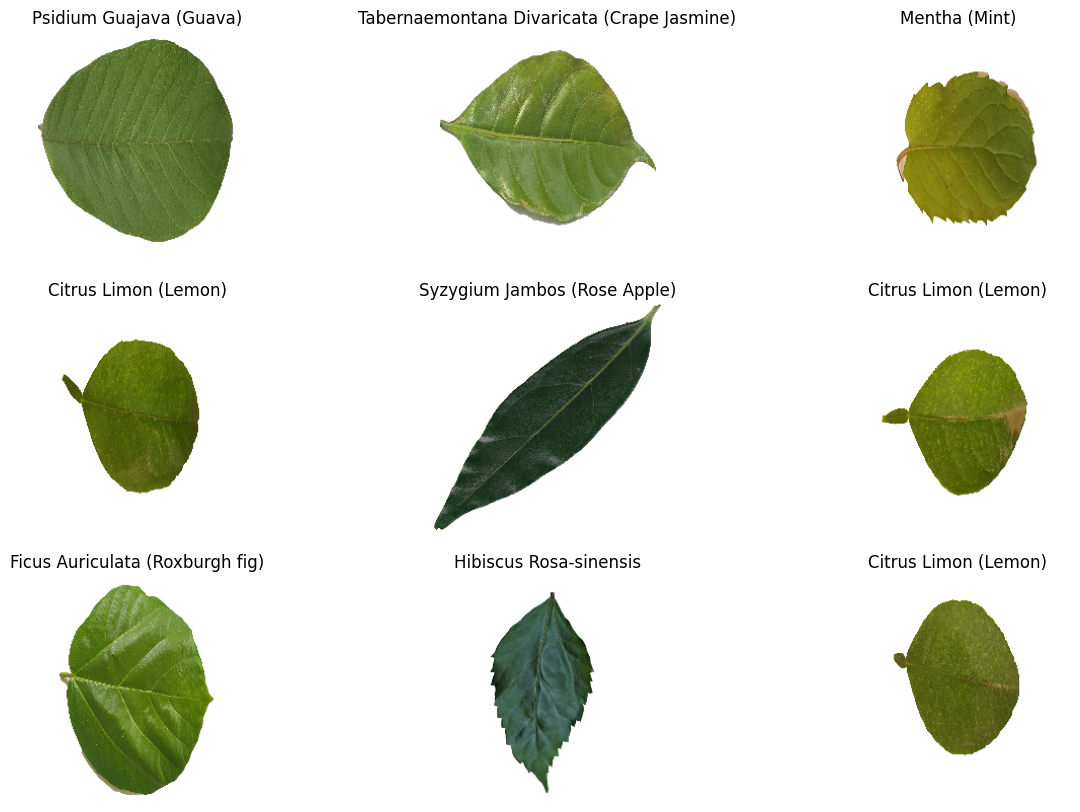

In [14]:
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
#provides pipeling for reading data and training
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

## Modelling

In [16]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential(
    [
        keras.layers.Rescaling(1./ 255),
        keras.layers.RandomFlip(),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomZoom(0.2,0.3)
    ]
)

## Using Pre-Trained ResNet50V2

In [17]:
#ResNet50V2 layers except for the last global average pooling and final dense layer.
pre_trained_layers = keras.applications.ResNet50V2(weights="imagenet", include_top=False,
           input_tensor=keras.Input(shape=IMG_SIZE))

94668760/94668760 [==============================] - 7s 0us/step


In [18]:
pre_trained_layers.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [19]:
#freezing the layers of ResNet
pre_trained_layers.trainable = False

In [20]:
pre_trained_layers.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [21]:
#Creating custom model
model = keras.Sequential([
    data_augmentation,                                                    # data augmentations
    pre_trained_layers,                                                   # ResNet pre-trained layers
    keras.layers.GlobalAveragePooling2D(),                                # Adding Global average Pooling 2d
    keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output')  # Final Dense Layer with 30 neurons
])

In [22]:
EPOCHS = 20
LR = 1e-3

In [23]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [24]:
#printing summary of custom model
model.build((1,224,224,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 224, 224, 3)          0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (1, 2048)                 0         
 GlobalAveragePooling2D)                                         
                                                                 
 output (Dense)              (1, 30)                   61470     
                                                                 
Total params: 23626270 (90.13 MB)
Trainable params: 61470 (240.12 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [25]:
# Callback -> Reduce Learning Rate on Plateau
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto',
                             min_delta=0.0001, cooldown=0, min_lr=0.00001)

In [26]:
#training the model
history = model.fit(train_ds, epochs=EPOCHS, validation_data=validation_ds, callbacks=callback)

Epoch 1/20
23/23 [==============================] - 138s 6s/step - loss: 2.5953 - accuracy: 0.3025 - val_loss: 1.5387 - val_accuracy: 0.5640 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - 223s 10s/step - loss: 1.1746 - accuracy: 0.7405 - val_loss: 0.8470 - val_accuracy: 0.7847 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - 116s 5s/step - loss: 0.7317 - accuracy: 0.8522 - val_loss: 0.5891 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 4/20
23/23 [==============================] - 131s 5s/step - loss: 0.5312 - accuracy: 0.9019 - val_loss: 0.4679 - val_accuracy: 0.8856 - lr: 0.0010
Epoch 5/20
23/23 [==============================] - 116s 5s/step - loss: 0.4400 - accuracy: 0.9230 - val_loss: 0.4045 - val_accuracy: 0.9019 - lr: 0.0010
Epoch 6/20
23/23 [==============================] - 104s 5s/step - loss: 0.4042 - accuracy: 0.9176 - val_loss: 0.3456 - val_accuracy: 0.9183 - lr: 0.0010
Epoch 7/20
23/23 [==============================] - 179s 8s/step - loss: 0.

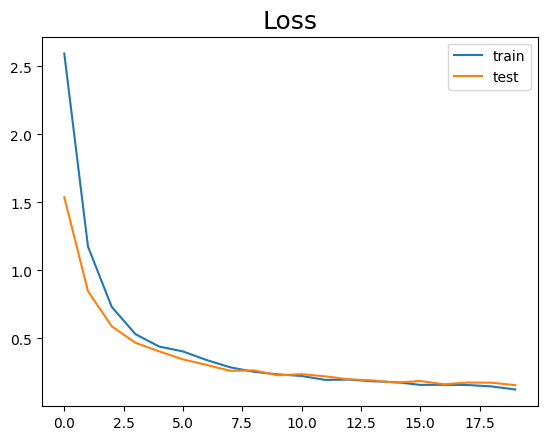

In [27]:
plt.title("Loss", fontdict={'fontsize':18})
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

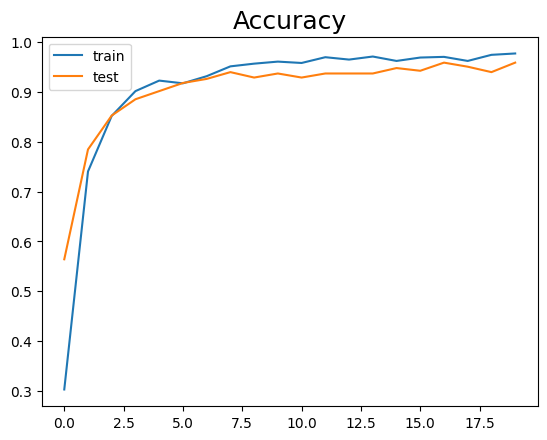

In [28]:
plt.title("Accuracy", fontdict={'fontsize':18})
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()

## Model Performance Analysis

In [30]:
!pip install plotly


^C


   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   --------------- ------------------------ 3.7/9.6 MB 24.3 MB/s eta 0:00:01
   ------------------------------- -------- 7.6/9.6 MB 18.8 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 17.7 MB/s eta 0:00:00


In [31]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [32]:
Y_train = []
X_train = []

In [33]:
for data in train_ds:
    X_train.extend(data[0].numpy())
    Y_train.extend(data[1].numpy())

In [34]:
Y_train = np.array(Y_train)
X_train = np.array(X_train)

In [35]:
y_train_pred_prob = model.predict(X_train)
y_train_pred = [np.argmax(i) for i in y_train_pred_prob]

46/46 [==============================] - 76s 2s/step


In [37]:
y_train_pred_prob.shape

(1468, 30)

In [38]:
#function to plot roc-auc curve
def roc_auc_curve(y_scores, y_true):
    # One hot encode the labels in order to plot them
    y_onehot = pd.get_dummies(y_true, columns=class_names)

    # Create an empty figure, and iteratively add new lines
    # every time we compute a new class
    fig = go.Figure()
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    for i in range(y_scores.shape[1]):
        y_true = y_onehot.iloc[:, i]
        y_score = y_scores[:, i]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_score = roc_auc_score(y_true, y_score)

        name = f"{class_names[i]} (AUC={auc_score:.2f})"
        fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

    fig.update_layout(
        title="ROC Curve",
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        yaxis=dict(scaleanchor="x", scaleratio=1),
        xaxis=dict(constrain='domain'),
        width=900, height=800
    )
    
    return fig

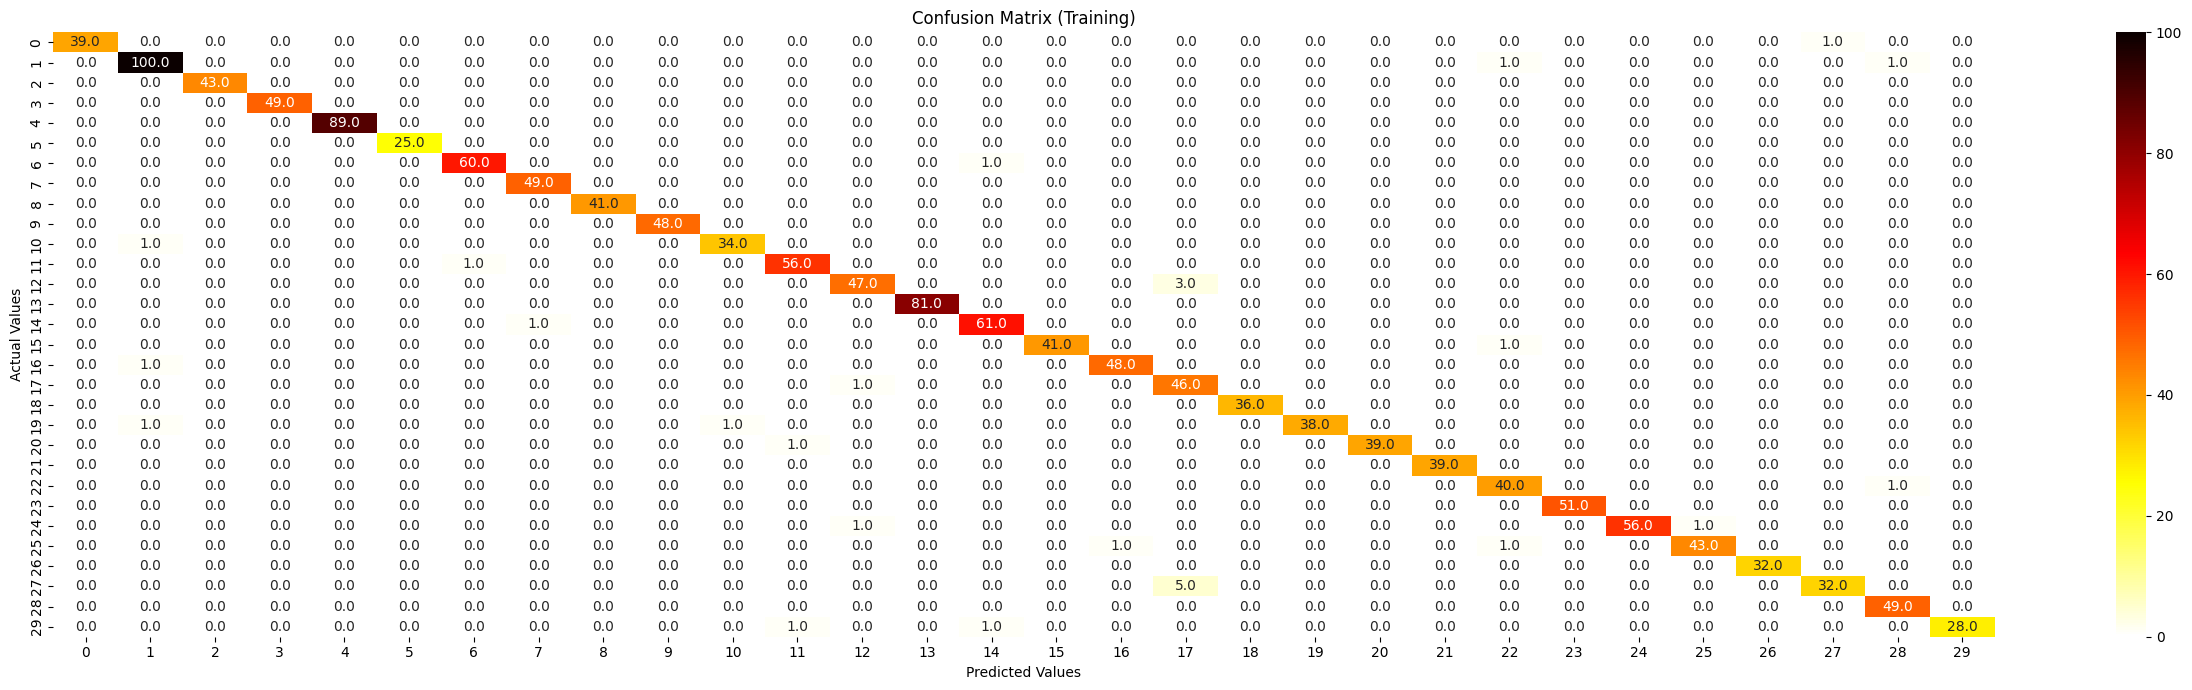

In [39]:
plt.figure(figsize=(25,7))
sb.heatmap(tf.math.confusion_matrix(labels=Y_train,predictions=y_train_pred),annot=True,fmt='.1f', cmap='hot_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix (Training)')
plt.tight_layout()
plt.show()

In [40]:
print("Classification Report for Training")
print(classification_report(Y_train, y_train_pred))

Classification Report for Training
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.97      0.98      0.98       102
           2       1.00      1.00      1.00        43
           3       1.00      1.00      1.00        49
           4       1.00      1.00      1.00        89
           5       1.00      1.00      1.00        25
           6       0.98      0.98      0.98        61
           7       0.98      1.00      0.99        49
           8       1.00      1.00      1.00        41
           9       1.00      1.00      1.00        48
          10       0.97      0.97      0.97        35
          11       0.97      0.98      0.97        57
          12       0.96      0.94      0.95        50
          13       1.00      1.00      1.00        81
          14       0.97      0.98      0.98        62
          15       1.00      0.98      0.99        42
          16       0.98      0.98      0.98   

In [42]:
!pip install -U nbformat


  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached jsonschema_specifications-2023.12.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached pkgutil_resolve_name-1.3.10-py3-none-any.whl.metadata (624 bytes)
  Using cached referencing-0.35.1-py3-none-any.whl.metadata (2.8 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached fastjsonschema-2.21.1-py3-none-any.whl (23 kB)
Using cached jsonschema_specifications-2023.12.1-py3-none-any.whl (18 kB)
Using cached pkgutil_resolve_name-1.3.10-py3-none-any.whl (4.7 kB)
Using cached referencing-0.35.1-py3-none-any.whl (26 kB)


In [46]:
import plotly.io as pio


In [47]:
roc_auc_curve(y_train_pred_prob, Y_train)

In [48]:
X_test = []
y_test = []

In [49]:
for data in validation_ds:
    X_test.extend(data[0].numpy())
    y_test.extend(data[1].numpy())

In [50]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [51]:
y_test_pred_prob = model.predict(X_test)
y_test_pred = [np.argmax(i) for i in y_test_pred_prob]

12/12 [==============================] - 16s 1s/step


In [52]:
np.unique(y_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

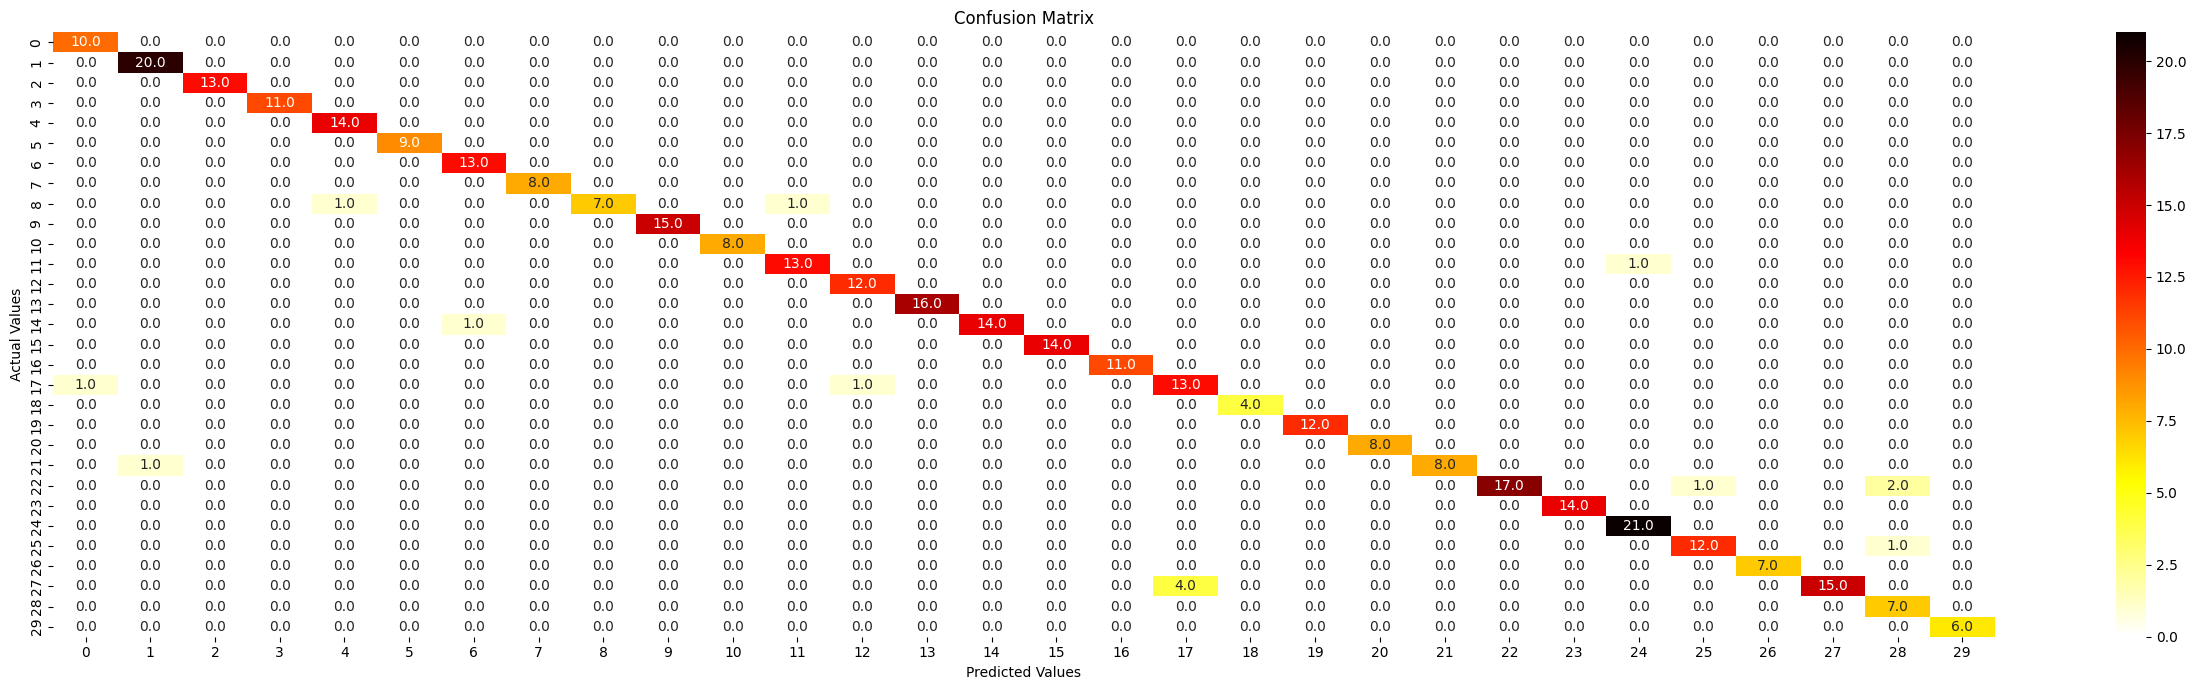

In [53]:
plt.figure(figsize=(25,7))
sb.heatmap(tf.math.confusion_matrix(labels=y_test,predictions=y_test_pred),annot=True,fmt='.1f', cmap='hot_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [54]:
print("Classification Report for Test")
print(classification_report(y_test, y_test_pred))

Classification Report for Test
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.95      1.00      0.98        20
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        11
           4       0.93      1.00      0.97        14
           5       1.00      1.00      1.00         9
           6       0.93      1.00      0.96        13
           7       1.00      1.00      1.00         8
           8       1.00      0.78      0.88         9
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00         8
          11       0.93      0.93      0.93        14
          12       0.92      1.00      0.96        12
          13       1.00      1.00      1.00        16
          14       1.00      0.93      0.97        15
          15       1.00      1.00      1.00        14
          16       1.00      1.00      1.00       

In [55]:
roc_auc_curve(y_test_pred_prob, y_test)

## Saving Model

In [56]:
from tensorflow.keras.models import save_model

In [57]:
save_model(model, 'transfer_learning.h5')